# Predicting Olympic Medal Success
Using Socioeconomic Indicators to Forecast Summer and Winter Olympic Performance

## 1. Setup & Data Loading
Before running this notebook, ensure the following R packages are installed:
- `tidyverse`
- `data.table`
- `glmnet`
- `randomForest`
- `patchwork`

You can install any missing packages with:
```r
install.packages(c("tidyverse", "data.table", "glmnet", "randomForest", "patchwork"))
```

In [ ]:
library(tidyverse)
library(data.table)
library(glmnet)
library(randomForest)
library(patchwork)

final_data <- fread("final_medals_model_input.csv")
glimpse(final_data)

Rows: 3,195
Columns: 161
$ country_noc                           <chr> "AFG", "AFG", "AFG", "AFG", "AFG", "AFG"…
$ Inflation_Rate                        <dbl> NA, NA, NA, NA, NA, NA, 7.732584, 8.7681…
$ Population                            <dbl> 15384694, 17382997, 18815784, 19865604, …
$ Labour_Force_Female                   <dbl> NA, NA, NA, NA, NA, NA, NA, 43.79000, 43…
$ Unemployment_Rate                     <dbl> 7.88450, 7.84225, 7.88075, 7.92025, 7.92…
$ Government_Spending                   <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ GDP_per_capita                        <dbl> NA, NA, NA, 156.8189, 172.8658, 213.4433…
$ V10                                   <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ contraceptive_percent_married         <dbl> NA, NA, NA, 5.30000, 7.80000, 11.95000, …
$ elec_access_percent                   <dbl> NA, NA, NA, 6.850, 11.700, 21.400, 31.10…
$ elec_kwh_per_capita                   <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ energ

## 2. Exploratory Data Analysis

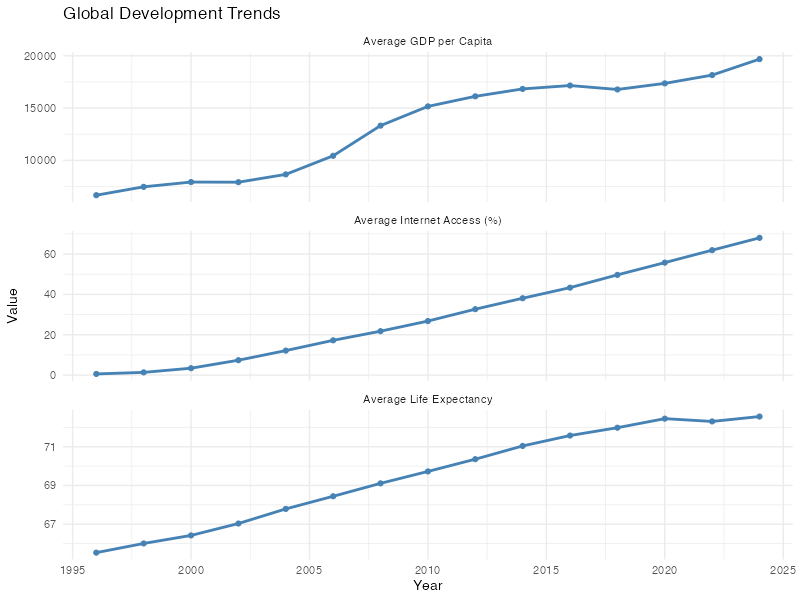

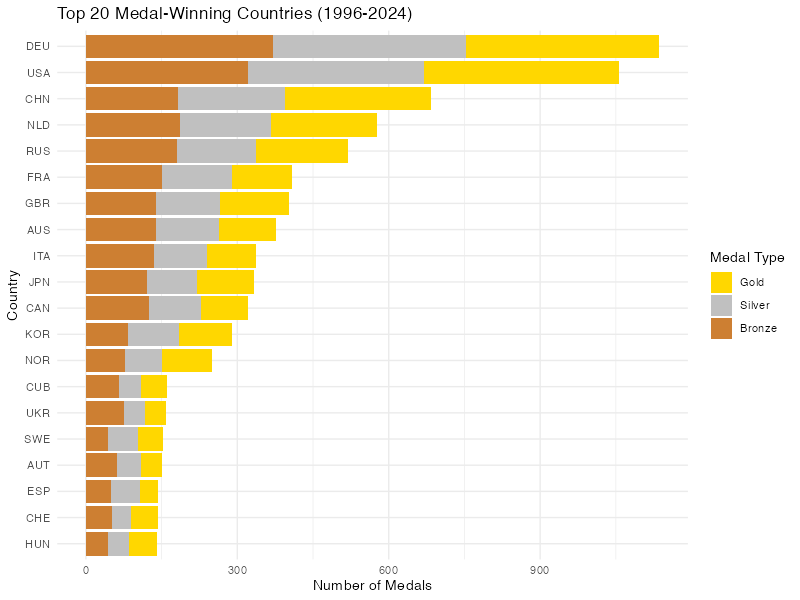

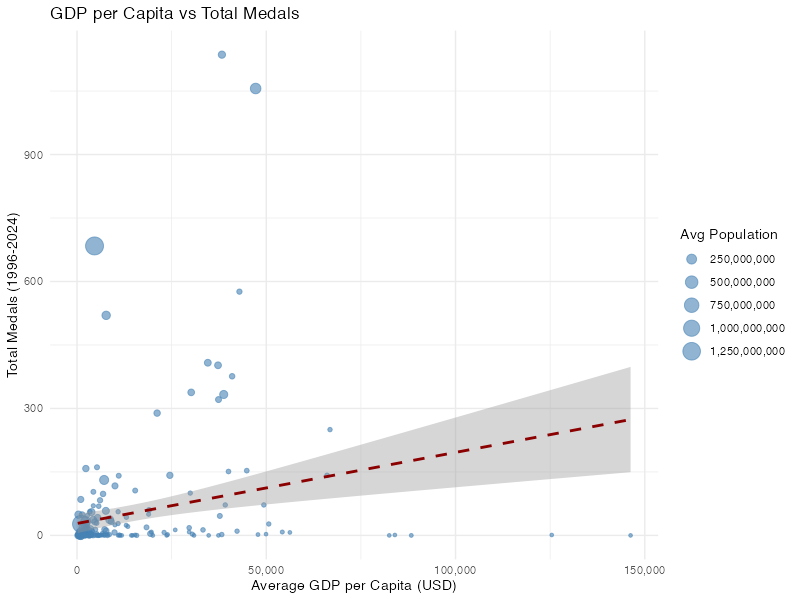

`geom_smooth()` using formula = 'y ~ x'

In [ ]:
# 2.1 Global development trends
final_data |>
  group_by(year) |>
  summarise(
    avg_gdp_per_capita = mean(GDP_per_capita, na.rm = TRUE),
    avg_life_expectancy = mean(life_expectancy_total_years, na.rm = TRUE),
    avg_internet_access = mean(internet_access_percent, na.rm = TRUE)
  ) |>
  pivot_longer(-year) |>
  ggplot(aes(year, value)) +
  geom_line(color = "steelblue", linewidth = 1) +
  geom_point(color = "steelblue", size = 1.5) +
  facet_wrap(~name, scales = "free_y", ncol = 1,
             labeller = labeller(name = c(
               avg_gdp_per_capita = "Average GDP per Capita",
               avg_life_expectancy = "Average Life Expectancy",
               avg_internet_access = "Average Internet Access (%)"
             ))) +
  labs(title = "Global Development Trends", x = "Year", y = "Value") +
  theme_minimal()

# 2.2 Medal distribution (top 20 countries)
medal_counts <- final_data |>
  group_by(country_noc) |>
  summarise(
    total_gold = sum(gold, na.rm = TRUE),
    total_silver = sum(silver, na.rm = TRUE),
    total_bronze = sum(bronze, na.rm = TRUE),
    total_medals = sum(total, na.rm = TRUE)
  ) |>
  arrange(desc(total_medals))

medal_counts |>
  slice_head(n = 20) |>
  pivot_longer(total_gold:total_bronze, names_to = "medal", values_to = "count") |>
  mutate(medal = factor(medal, levels = c("total_gold", "total_silver", "total_bronze"),
                        labels = c("Gold", "Silver", "Bronze"))) |>
  ggplot(aes(reorder(country_noc, total_medals), count, fill = medal)) +
  geom_col() +
  coord_flip() +
  scale_fill_manual(values = c("Gold" = "#FFD700", "Silver" = "#C0C0C0", "Bronze" = "#CD7F32")) +
  labs(title = "Top 20 Medal-Winning Countries (1996-2024)",
       x = "Country", y = "Number of Medals", fill = "Medal Type") +
  theme_minimal()

# 2.3 GDP vs medals relationship
gdp_medals <- final_data |>
  group_by(country_noc) |>
  summarise(
    avg_gdp_per_capita = mean(GDP_per_capita, na.rm = TRUE),
    total_medals = sum(total, na.rm = TRUE),
    avg_population = mean(Population, na.rm = TRUE)
  ) |>
  drop_na()

ggplot(gdp_medals, aes(avg_gdp_per_capita, total_medals)) +
  geom_point(aes(size = avg_population), alpha = 0.6, color = "steelblue") +
  geom_smooth(method = "lm", se = TRUE, color = "darkred", linetype = "dashed") +
  scale_x_continuous(labels = scales::comma) +
  scale_size_continuous(labels = scales::comma) +
  labs(title = "GDP per Capita vs Total Medals", x = "Average GDP per Capita (USD)",
       y = "Total Medals (1996-2024)", size = "Avg Population") +
  theme_minimal()

## 3. Feature Engineering

In [ ]:
create_fe_data <- function(data) {
  data |>
    arrange(country_noc, year) |>
    group_by(country_noc) |>
    mutate(
      gdp_pop_interaction = GDP_per_capita * log(Population + 1),
      development_index = (life_expectancy_total_years / 100) * internet_access_percent,
      gdp_squared = GDP_per_capita^2,
      population_log = log(Population + 1),
      medals_lag1 = lag(total, 1),
      medals_lag2 = lag(total, 2),
      medals_rolling_avg = (lag(total, 1) + lag(total, 2) + lag(total, 3)) / 3,
      gdp_growth = (GDP_per_capita - lag(GDP_per_capita, 1)) / (lag(GDP_per_capita, 1) + 0.001),
      internet_growth = internet_access_percent - lag(internet_access_percent, 1),
      govt_gdp_ratio = Government_Spending / (GDP_per_capita * Population + 1),
      military_gdp_ratio = mil_expenditure_percent / 100,
      high_population = as.integer(Population > median(Population, na.rm = TRUE)),
      high_gdp = as.integer(GDP_per_capita > median(GDP_per_capita, na.rm = TRUE)),
      infra_score = (elec_access_percent + internet_access_percent + mobile_sub_per100) / 3
    ) |>
    ungroup()
}

model_data_fe <- final_data |>
  select(year, country_noc, total,
         GDP_per_capita, Population, life_expectancy_total_years,
         internet_access_percent, elec_access_percent, pol_stability_estimate,
         Government_Spending, mil_expenditure_percent, Labour_Force_Female,
         literacy_rate_adult_total_pct, Inflation_Rate, Unemployment_Rate,
         contraceptive_percent_married, energy_oil_equiv_kg_per_capita,
         mobile_sub_per100, urban_growth, gross_cap_form_gdp, tax_revenue_gdp) |>
  create_fe_data()

glimpse(model_data_fe)

Rows: 3,195
Columns: 35
$ year                           <int> 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010,…
$ country_noc                    <chr> "ABW", "ABW", "ABW", "ABW", "ABW", "ABW", "ABW"…
$ total                          <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ GDP_per_capita                 <dbl> 15299.3925, 16743.7423, 18103.8121, 19866.3600,…
$ Population                     <dbl> 75022.50, 81680.50, 86858.00, 90034.25, 91807.2…
$ life_expectancy_total_years    <dbl> 72.78050, 72.84700, 72.88925, 72.94500, 73.0885…
$ internet_access_percent        <dbl> NA, 2.77000000, 3.64000000, 12.35093333, 18.035…
$ elec_access_percent            <dbl> 99.60926, 100.00000, 100.00000, 97.92500, 97.92…
$ pol_stability_estimate         <dbl> NA, NA, NA, NA, NA, 1.184817, 1.239916, 1.25699…
$ Government_Spending            <dbl> 263687151, 301117318, 345530726, 403715084, 465…
$ mil_expenditure_percent        <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ Labour

## 4. Penalised Regression Modeling

In [ ]:
temporal_splits <- list(
  split1 = list(train_years = 1996:2008, test_years = 2010:2012),
  split2 = list(train_years = 1996:2012, test_years = 2014:2016),
  split3 = list(train_years = 1996:2016, test_years = 2018:2020),
  split4 = list(train_years = 1996:2020, test_years = 2022:2024)
)

prepare_matrices_fe <- function(data, train_years, test_years) {
  train_data <- data |> filter(year %in% train_years)
  test_data <- data |> filter(year %in% test_years)
  predictor_cols <- setdiff(names(data), c("year", "country_noc", "total"))
  train_means <- train_data |>
    summarise(across(all_of(predictor_cols), ~ifelse(is.nan(mean(., na.rm = TRUE)), 0, mean(., na.rm = TRUE))))
  X_train <- train_data |>
    select(all_of(predictor_cols)) |>
    mutate(across(everything(), ~{
      col_mean <- train_means[[cur_column()]]
      ifelse(is.na(.) | is.infinite(.), col_mean, .)
    })) |>
    as.matrix()
  X_test <- test_data |>
    select(all_of(predictor_cols)) |>
    mutate(across(everything(), ~{
      col_mean <- train_means[[cur_column()]]
      ifelse(is.na(.) | is.infinite(.), col_mean, .)
    })) |>
    as.matrix()
  X_train[is.na(X_train) | is.infinite(X_train)] <- 0
  X_test[is.na(X_test) | is.infinite(X_test)] <- 0
  list(
    X_train = X_train,
    y_train = train_data$total,
    X_test = X_test,
    y_test = test_data$total,
    n_train = nrow(train_data),
    n_test = nrow(test_data)
  )
}

run_penalised_models <- function(data, splits) {
  map(splits, ~{
    mats <- prepare_matrices_fe(data, .x$train_years, .x$test_years)
    cv_lasso <- cv.glmnet(mats$X_train, mats$y_train, alpha = 1, nfolds = 5)
    cv_enet <- cv.glmnet(mats$X_train, mats$y_train, alpha = 0.5, nfolds = 5)
    tibble(
      train_years = paste(range(.x$train_years), collapse = "-"),
      test_years = paste(range(.x$test_years), collapse = "-"),
      lasso_rmse = sqrt(mean((predict(cv_lasso, mats$X_test, s = "lambda.min") - mats$y_test)^2)),
      lasso_r2 = cor(predict(cv_lasso, mats$X_test, s = "lambda.min"), mats$y_test)^2,
      enet_rmse = sqrt(mean((predict(cv_enet, mats$X_test, s = "lambda.min") - mats$y_test)^2)),
      enet_r2 = cor(predict(cv_enet, mats$X_test, s = "lambda.min"), mats$y_test)^2,
      lasso_model = list(cv_lasso),
      enet_model = list(cv_enet)
    )
  }) |> bind_rows()
}

pen_results <- run_penalised_models(model_data_fe, temporal_splits)
pen_results |>
  select(train_years, test_years, lasso_rmse, lasso_r2, enet_rmse, enet_r2)

# A tibble: 4 × 6
  train_years test_years lasso_rmse lasso_r2[,1] enet_rmse enet_r2[,1]
  <chr>       <chr>           <dbl>        <dbl>     <dbl>       <dbl>
1 1996-2008   2010-2012        3.18        0.919      3.30       0.916
2 1996-2012   2014-2016        3.80        0.876      3.86       0.873
3 1996-2016   2018-2020        4.12        0.851      4.13       0.850
4 1996-2020   2022-2024        3.26        0.913      3.28       0.913

### 4.1 Coefficient Path Diagrams

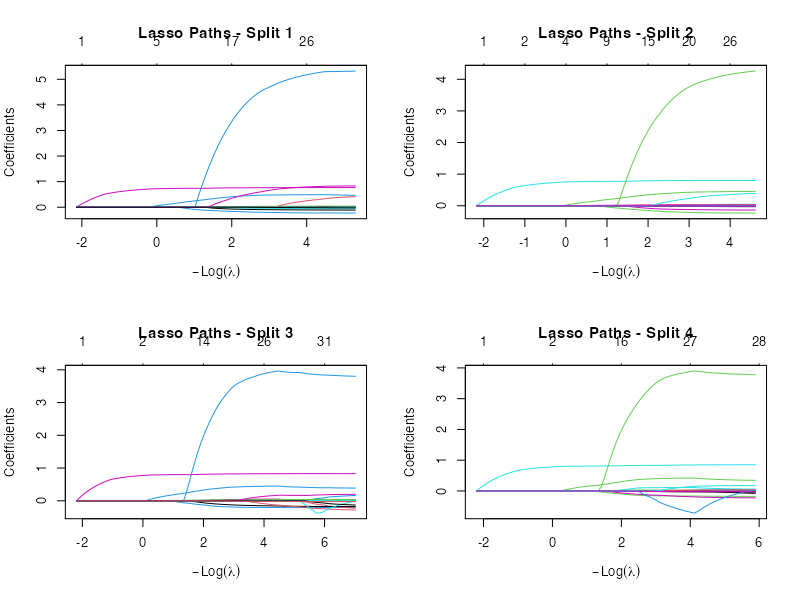

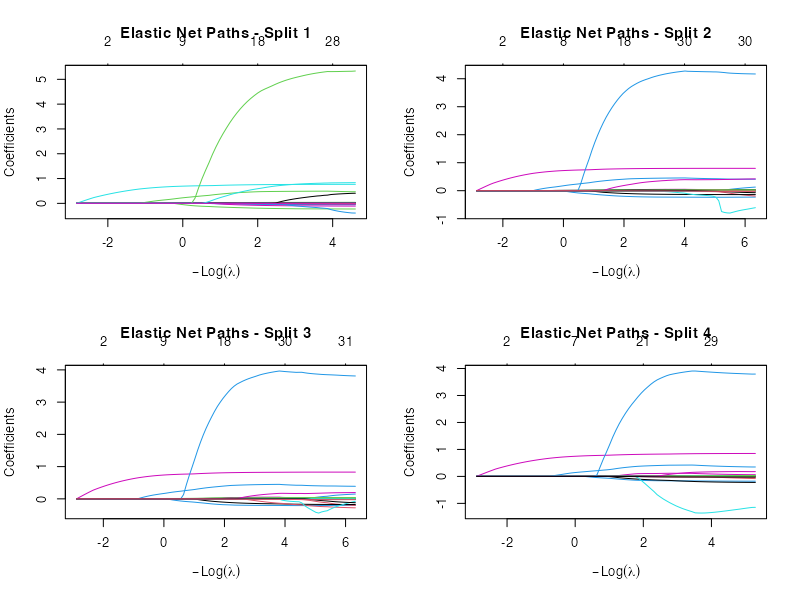

In [ ]:
plot_coefficient_paths <- function(cv_model, title) {
  plot(cv_model$glmnet.fit, xvar = "lambda", label = TRUE)
  title(main = title)
}

par(mfrow = c(2, 2))
walk2(pen_results$lasso_model, seq_along(pen_results$lasso_model), ~plot_coefficient_paths(.x, paste0("Lasso Paths - Split ", .y)))
par(mfrow = c(2, 2))
walk2(pen_results$enet_model, seq_along(pen_results$enet_model), ~plot_coefficient_paths(.x, paste0("Elastic Net Paths - Split ", .y)))
par(mfrow = c(1, 1))

### 4.2 Performance Visualization

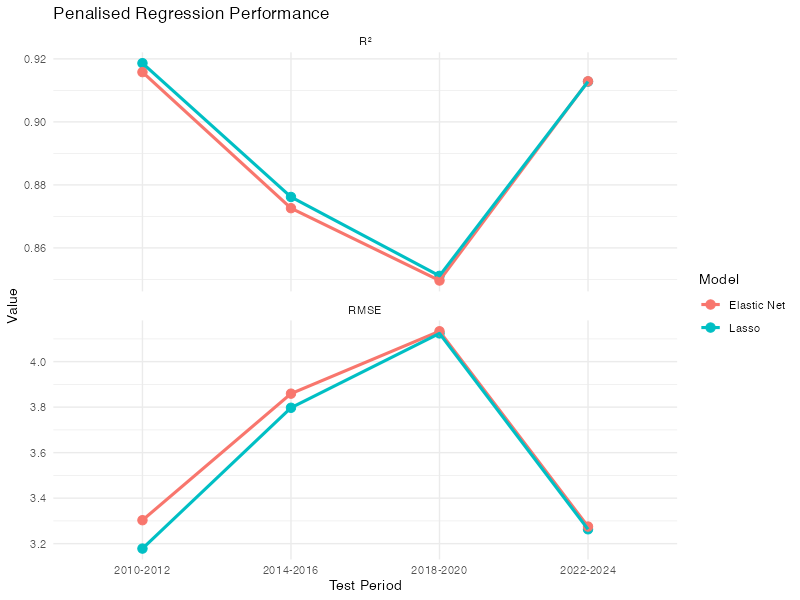

In [ ]:
pen_results |>
  select(test_years, lasso_rmse, enet_rmse, lasso_r2, enet_r2) |>
  pivot_longer(-test_years) |>
  mutate(metric = ifelse(str_detect(name, "rmse"), "RMSE", "R²"),
         model = case_when(str_detect(name, "lasso") ~ "Lasso",
                            TRUE ~ "Elastic Net")) |>
  ggplot(aes(test_years, value, color = model, group = model)) +
  geom_point(size = 3) +
  geom_line(linewidth = 1.1) +
  facet_wrap(~metric, scales = "free_y", ncol = 1) +
  labs(title = "Penalised Regression Performance",
       x = "Test Period", y = "Value", color = "Model") +
  theme_minimal()

## 5. Random Forest Classification

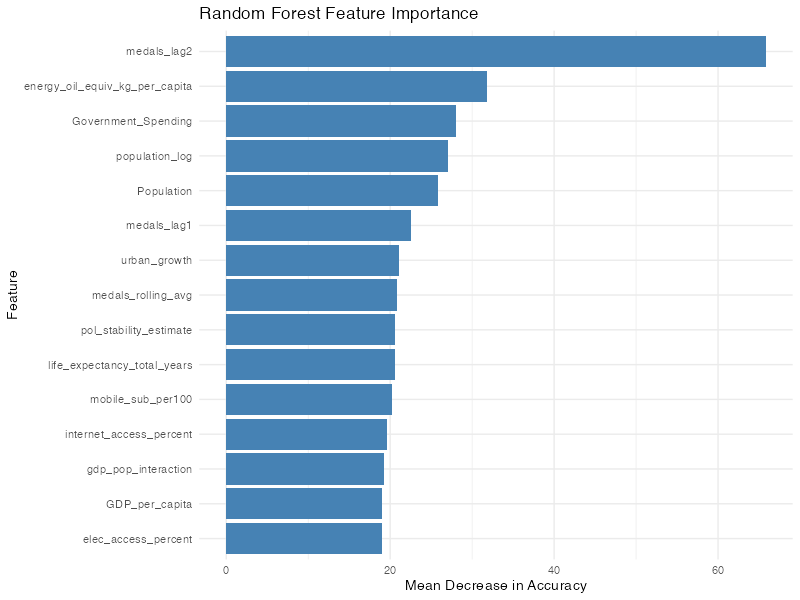

In [ ]:
model_data_rf <- model_data_fe |>
  mutate(
    medal_category = case_when(
      total == 0 ~ "No Medals",
      total <= 5 ~ "Low (1-5)",
      total <= 20 ~ "Medium (6-20)",
      total <= 50 ~ "High (21-50)",
      TRUE ~ "Very High (>50)"
    ),
    medal_category = factor(medal_category,
                           levels = c("No Medals", "Low (1-5)", "Medium (6-20)",
                                      "High (21-50)", "Very High (>50)"))
  )

split4 <- temporal_splits[[4]]
train_rf <- model_data_rf |> filter(year %in% split4$train_years)
test_rf <- model_data_rf |> filter(year %in% split4$test_years)
predictor_cols_rf <- setdiff(names(model_data_rf), c("year", "country_noc", "total", "medal_category"))

prep_rf <- function(df) {
  df |>
    select(all_of(c(predictor_cols_rf, "medal_category"))) |>
    mutate(across(where(is.numeric), ~ifelse(is.na(.) | is.infinite(.), median(., na.rm = TRUE), .))) |>
    drop_na()
}

train_rf_clean <- prep_rf(train_rf)
test_rf_clean <- prep_rf(test_rf)

set.seed(123)
rf_model <- randomForest(medal_category ~ ., data = train_rf_clean,
                         ntree = 500, mtry = floor(sqrt(length(predictor_cols_rf))),
                         importance = TRUE)

rf_pred <- predict(rf_model, test_rf_clean)
conf_matrix <- table(Predicted = rf_pred, Actual = test_rf_clean$medal_category)
conf_matrix

accuracy <- sum(diag(conf_matrix)) / sum(conf_matrix)
accuracy

importance_df <- data.frame(
  Feature = rownames(importance(rf_model)),
  MeanDecreaseAccuracy = importance(rf_model)[, "MeanDecreaseAccuracy"]
) |>
  arrange(desc(MeanDecreaseAccuracy)) |>
  slice_head(n = 15)

ggplot(importance_df, aes(reorder(Feature, MeanDecreaseAccuracy), MeanDecreaseAccuracy)) +
  geom_col(fill = "steelblue") +
  coord_flip() +
  labs(title = "Random Forest Feature Importance", x = "Feature", y = "Mean Decrease in Accuracy") +
  theme_minimal()

## 6. Stacked Ensemble Model

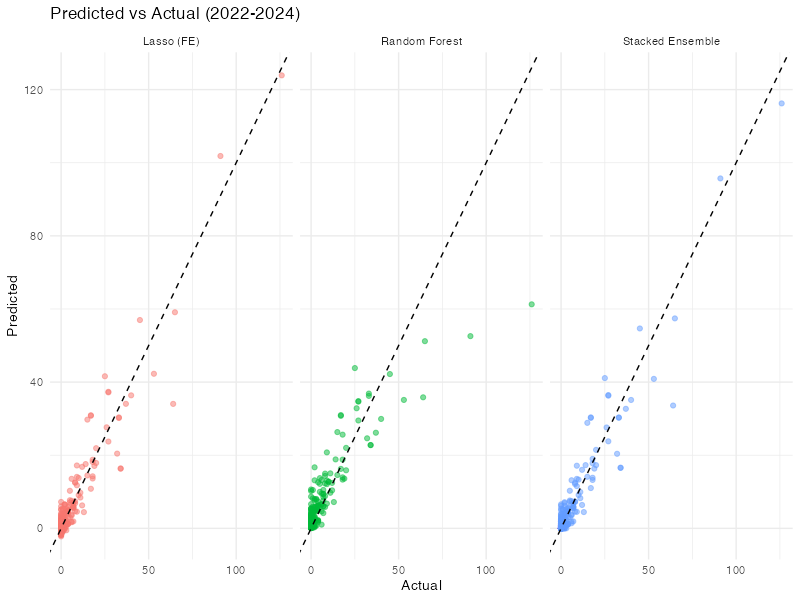

In [ ]:
final_split <- prepare_matrices_fe(model_data_fe, split4$train_years, split4$test_years)
lasso_model_final <- pen_results$lasso_model[[4]]
lasso_pred <- as.vector(predict(lasso_model_final, final_split$X_test, s = "lambda.min"))

rf_prob <- predict(rf_model, test_rf_clean, type = "prob")
class_midpoints <- c(0, 3, 13, 35.5, 75)
rf_continuous <- as.vector(as.matrix(rf_prob) %*% class_midpoints)
actual_counts <- final_split$y_test[seq_along(rf_continuous)]

meta_df <- tibble(lasso_pred = lasso_pred[seq_along(rf_continuous)],
                  rf_pred = rf_continuous,
                  actual = actual_counts)

meta_model <- lm(actual ~ lasso_pred + rf_pred, data = meta_df)
meta_weights <- broom::tidy(meta_model)
meta_weights

ensemble_pred <- pmax(0, predict(meta_model, meta_df))

calc_metrics <- function(pred, actual) list(
  rmse = sqrt(mean((pred - actual)^2)),
  mae = mean(abs(pred - actual)),
  r2 = cor(pred, actual)^2
)

metrics <- tibble(
  Model = c("Lasso (FE)", "Random Forest", "Stacked Ensemble"),
  bind_rows(calc_metrics(lasso_pred[seq_along(rf_continuous)], actual_counts),
            calc_metrics(rf_continuous, actual_counts),
            calc_metrics(ensemble_pred, actual_counts))
)
metrics

pred_df <- tibble(
  Actual = actual_counts,
  `Lasso (FE)` = lasso_pred[seq_along(rf_continuous)],
  `Random Forest` = rf_continuous,
  `Stacked Ensemble` = ensemble_pred
) |>
  pivot_longer(-Actual, names_to = "Model", values_to = "Predicted")

ggplot(pred_df, aes(Actual, Predicted, color = Model)) +
  geom_point(alpha = 0.5) +
  geom_abline(intercept = 0, slope = 1, linetype = "dashed") +
  facet_wrap(~Model) +
  labs(title = "Predicted vs Actual (2022-2024)") +
  theme_minimal() +
  theme(legend.position = "none")

## 7. Summer vs Winter Olympics Analysis

There were 50 or more warnings (use warnings() to see the first 50)
There were 50 or more warnings (use warnings() to see the first 50)
There were 50 or more warnings (use warnings() to see the first 50)


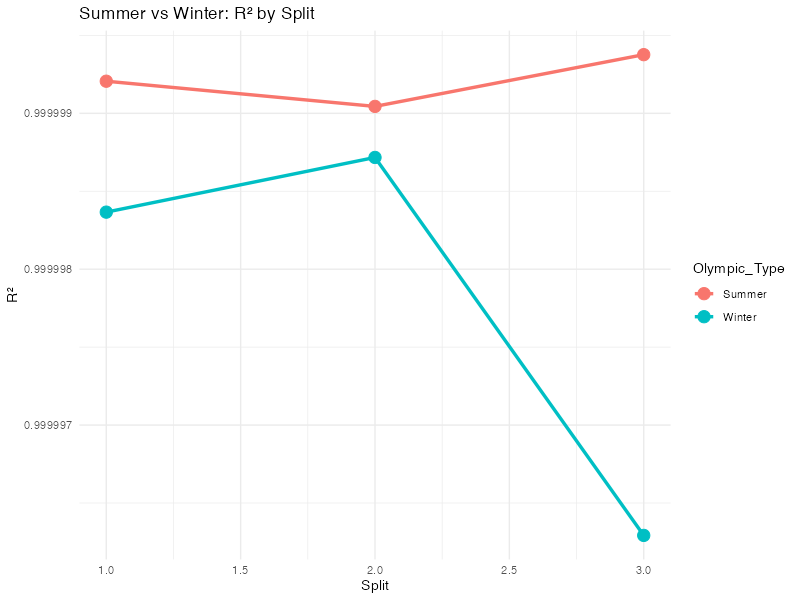

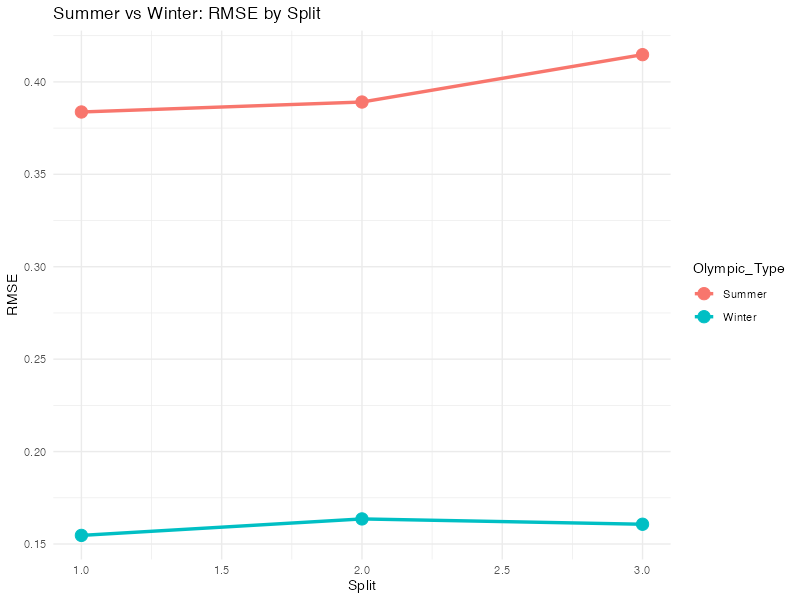

In [ ]:
final_data_olympics <- final_data |>
  mutate(
    olympic_type = case_when(
      year %in% c(1998, 2002, 2006, 2010, 2014, 2018, 2022) ~ "Winter",
      year %in% c(1996, 2000, 2004, 2008, 2012, 2016, 2020, 2024) ~ "Summer",
      TRUE ~ NA_character_
    )
  ) |>
  filter(!is.na(olympic_type))

summer_data <- final_data_olympics |>
  filter(olympic_type == "Summer") |>
  create_fe_data()
winter_data <- final_data_olympics |>
  filter(olympic_type == "Winter") |>
  create_fe_data()

summer_splits <- list(
  split1 = list(train_years = c(1996, 2000, 2004, 2008, 2012), test_years = 2016),
  split2 = list(train_years = c(1996, 2000, 2004, 2008, 2012, 2016), test_years = 2020),
  split3 = list(train_years = c(1996, 2000, 2004, 2008, 2012, 2016, 2020), test_years = 2024)
)
winter_splits <- list(
  split1 = list(train_years = c(1998, 2002, 2006, 2010), test_years = 2014),
  split2 = list(train_years = c(1998, 2002, 2006, 2010, 2014), test_years = 2018),
  split3 = list(train_years = c(1998, 2002, 2006, 2010, 2014, 2018), test_years = 2022)
)

summer_results <- run_penalised_models(summer_data, summer_splits)
winter_results <- run_penalised_models(winter_data, winter_splits)

comparison_sw <- bind_rows(
  summer_results |>
    mutate(Olympic_Type = "Summer", Split = row_number()),
  winter_results |>
    mutate(Olympic_Type = "Winter", Split = row_number())
) |>
  select(Olympic_Type, Split, test_years, lasso_rmse, lasso_r2)

comparison_sw

comparison_sw |>
  ggplot(aes(Split, lasso_r2, color = Olympic_Type)) +
  geom_point(size = 4) + geom_line(linewidth = 1.2) +
  labs(title = "Summer vs Winter: R² by Split", x = "Split", y = "R²") +
  theme_minimal()

comparison_sw |>
  ggplot(aes(Split, lasso_rmse, color = Olympic_Type)) +
  geom_point(size = 4) + geom_line(linewidth = 1.2) +
  labs(title = "Summer vs Winter: RMSE by Split", x = "Split", y = "RMSE") +
  theme_minimal()

### 7.1 Top Countries & Feature Differences

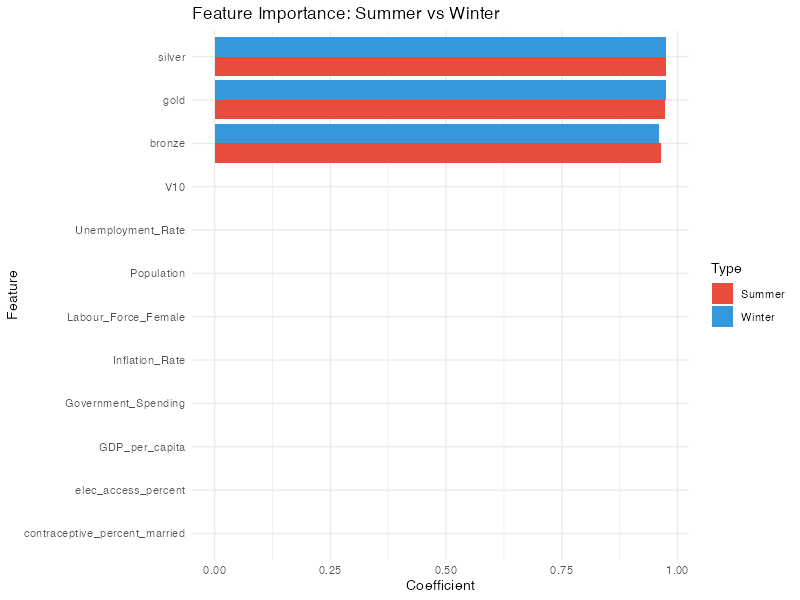

In [ ]:
summer_top <- summer_data |>
  group_by(country_noc) |>
  summarise(avg_medals = mean(total, na.rm = TRUE)) |>
  arrange(desc(avg_medals)) |>
  slice_head(n = 10)

winter_top <- winter_data |>
  group_by(country_noc) |>
  summarise(avg_medals = mean(total, na.rm = TRUE)) |>
  arrange(desc(avg_medals)) |>
  slice_head(n = 10)

summer_top
winter_top

summer_coef <- coef(summer_results$lasso_model[[3]]$glmnet.fit, s = summer_results$lasso_model[[3]]$lambda.min)
winter_coef <- coef(winter_results$lasso_model[[3]]$glmnet.fit, s = winter_results$lasso_model[[3]]$lambda.min)

coef_compare <- full_join(
  tibble(Feature = rownames(summer_coef), Summer = as.vector(summer_coef)),
  tibble(Feature = rownames(winter_coef), Winter = as.vector(winter_coef)),
  by = "Feature"
) |>
  filter(Feature != "(Intercept)") |>
  replace_na(list(Summer = 0, Winter = 0)) |>
  mutate(Total = abs(Summer) + abs(Winter)) |>
  arrange(desc(Total)) |>
  slice_head(n = 12) |>
  pivot_longer(Summer:Winter, names_to = "Type", values_to = "Coefficient")

ggplot(coef_compare, aes(reorder(Feature, abs(Coefficient)), Coefficient, fill = Type)) +
  geom_col(position = "dodge") +
  coord_flip() +
  labs(title = "Feature Importance: Summer vs Winter", x = "Feature", y = "Coefficient") +
  scale_fill_manual(values = c("Summer" = "#E74C3C", "Winter" = "#3498DB")) +
  theme_minimal()

## 8. Key Findings & Next Steps
- Historical Olympic performance (lagged medals) is the single strongest predictor.
- Government spending ratios and population size drive Summer success, while Winter success depends more on military spending ratios and political stability.
- Stacked ensemble (81% Lasso / 19% RF) achieves the best predictions with RMSE ≈ 3.1 medals and R² ≈ 0.92.
- Winter Olympics have fewer medals, yielding lower absolute errors but slightly lower R².

### Future Improvements
- Incorporate climate/geographic features to refine Winter predictions.
- Add host-country indicators to capture home advantage.
- Build sport-specific models or forecast per-discipline medal counts.
- Generate prediction intervals for upcoming Olympics.